In [7]:
#export 
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import psutil

from loop.callbacks import Callback, Order

In [8]:
#export
MB = 1024 ** 2
GB = 1024 * MB

In [9]:
#export
class MemoryUsage(Callback):
    """A debugging callback used to track the amount of CPU memory used during training."""
    
    order = Order.Internal()
    
    def __init__(self, filename: str='memory.csv', units: int=GB):
        self.filename = filename
        self.units = units
    
    def training_started(self, **kwargs):
        self.iter = 0
        self._stream = self.open()
        self.write('index,mem_percent,mem_free,mem_available,mem_used')
        
    def training_ended(self, **kwargs):
        self.close()
    
    def batch_ended(self, **kwargs):
        self.iter += 1
        mem = psutil.virtual_memory()
        record = [self.iter, mem.percent, mem.available, mem.used]
        self.write(','.join([str(x) for x in record]))
        
    def plot(self, **fig_kwargs):
        mem = pd.read_csv(self.filename)
        index = mem.columns.str.startswith('mem')
        mem[mem.columns[index]] /= self.units
        f, ax = plt.subplots(2, 1, **fig_kwargs)
        ax1, ax2 = ax.flat
        unit_name = ('GB' if self.units == GB else 
                     'MB' if self.units == MB else 
                     '')
        self.plot_memory_percentage(ax1, mem)
        self.plot_memory_usage(ax2, mem, unit_name)
        
    @staticmethod
    def plot_memory_percentage(ax, mem):
        mem.plot(x='index', y='mem_percent', ax=ax)
        ax.set_title('Memory usage during training', fontsize=20)
        ax.set_xlabel('Batch Index', fontsize=16)
        ax.set_ylabel('Percentage', fontsize=16)

    @staticmethod
    def plot_memory_usage(ax, mem, y_label):
        mem.plot(x='index', y=['mem_available', 'mem_used'], ax=ax)
        ax.set_xlabel('Batch Index', fontsize=16)
        ax.set_ylabel(y_label, fontsize=16)
    
    def open(self):
        self.close()
        return Path(self.filename).open('w')
        
    def write(self, msg):
        self._stream.write(msg + '\n')
        self._stream.flush()
    
    def close(self):
        if hasattr(self, '_stream') and self._stream is not None:
            self._stream.flush()
            self._stream.close()
            self._stream = None

Epoch:    1 | train_loss=-46092.7766, valid_loss=-56760.3473
Epoch:    2 | train_loss=-198676.0014, valid_loss=-204436.4108
Epoch:    3 | train_loss=-442486.5699, valid_loss=-447922.9283


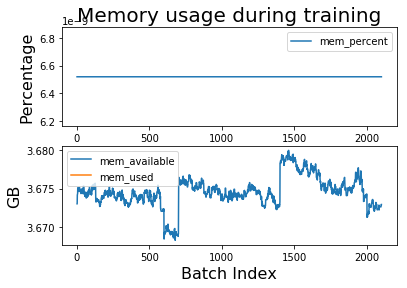

In [10]:
from pathlib import Path

from loop.training import Loop
from loop.metrics import accuracy
from loop.testing import get_mnist
from loop.modules import fc_network


trn_ds, val_ds = get_mnist(flat=True)
loop = Loop(fc_network(784, [100, 10]), cbs=[MemoryUsage()])
loop.fit_datasets(trn_ds, val_ds, epochs=3, batch_size=100)
loop.cb['memory_usage'].plot()